In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
df = pd.read_csv('data/cleaned_student_lifestyle_dataset.csv')

In [4]:
df.head()

,student_id,study_hours_per_day,extracurricular_hours_per_day,sleep_hours_per_day,social_hours_per_day,physical_activity_hours_per_day,gpa,stress_level,stress_level_numeric,gpa_group
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate,2,2.5-3
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low,1,2.5-3
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low,1,2.5-3
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate,2,2.5-3
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High,3,3.5-4


Filter data to include only Low and High stress levels

In [5]:
df_filtered = df[df['stress_level'].isin(['Low', 'High'])]

In [6]:
df_filtered.head()

,student_id,study_hours_per_day,extracurricular_hours_per_day,sleep_hours_per_day,social_hours_per_day,physical_activity_hours_per_day,gpa,stress_level,stress_level_numeric,gpa_group
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low,1,2.5-3
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low,1,2.5-3
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High,3,3.5-4
6,7,8.0,0.7,5.3,5.7,4.3,3.08,High,3,3-3.5
7,8,8.4,1.8,5.6,3.0,5.2,3.20,High,3,3-3.5


### 1. Check the visualization of the data

Define low and high stress groups

In [7]:
low_stress = df[df['stress_level'] == 'Low']['physical_activity_hours_per_day']
high_stress = df[df['stress_level'] == 'High']['physical_activity_hours_per_day']

Visual exploration of the groups

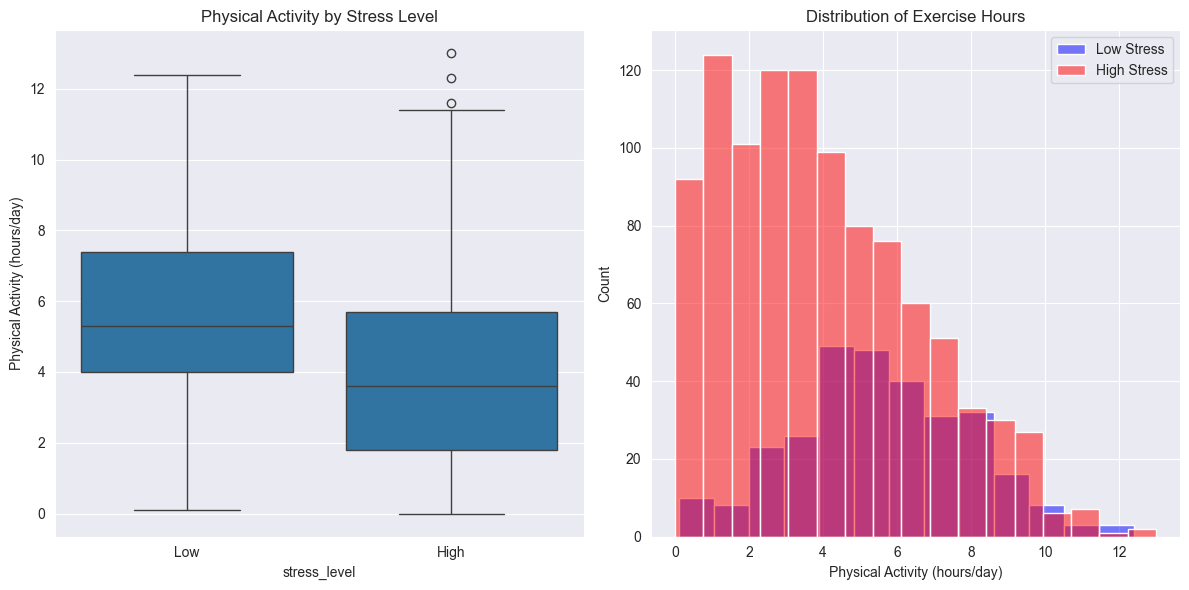

In [8]:
plt.figure(figsize=(12, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='stress_level', y='physical_activity_hours_per_day', data=df_filtered)
plt.title('Physical Activity by Stress Level')
plt.ylabel('Physical Activity (hours/day)')

# Histogram
plt.subplot(1, 2, 2)
sns.histplot(low_stress, color='blue', alpha=0.5, label='Low Stress')
sns.histplot(high_stress, color='red', alpha=0.5, label='High Stress')
plt.title('Distribution of Exercise Hours')
plt.xlabel('Physical Activity (hours/day)')
plt.legend()

plt.tight_layout()
plt.show()

Graphs show that low-stress students tend to have higher physical activity hours per day compared to high-stress students. Let's perform a statistical test to confirm this observation.

### 2. Before testing we need to check the normality of the data

Visual check with Q-Q plot

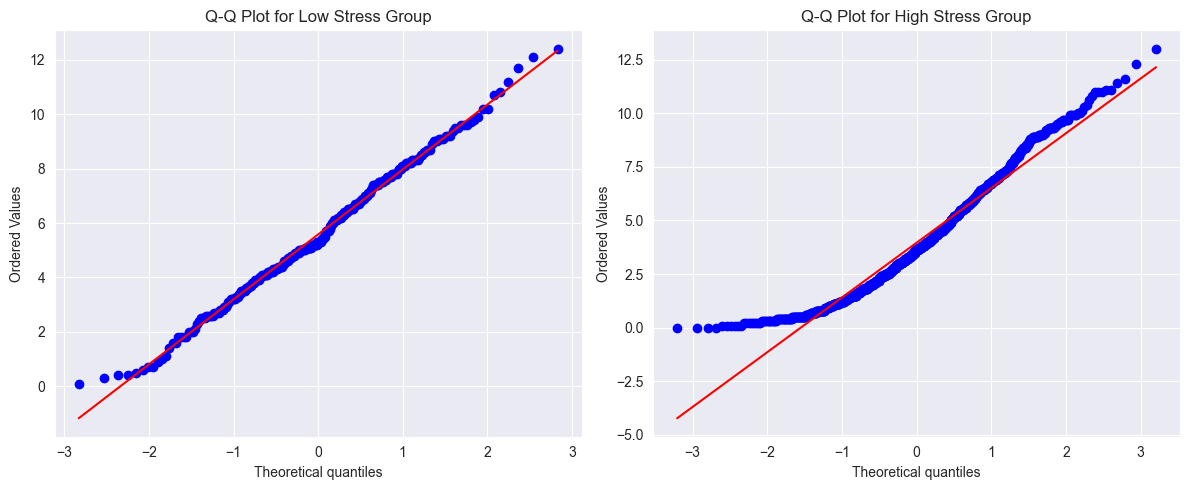

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
stats.probplot(low_stress, dist="norm", plot=plt)
plt.title('Q-Q Plot for Low Stress Group')

plt.subplot(1, 2, 2)
stats.probplot(high_stress, dist="norm", plot=plt)
plt.title('Q-Q Plot for High Stress Group')

plt.tight_layout()
plt.show()

as we saw before the data for high-stress group is not normally distributed, let's use the Shapiro-Wilk test to confirm this

In [10]:
shapiro_low = stats.shapiro(low_stress)
shapiro_high = stats.shapiro(high_stress)
print(f"Low stress group: W={shapiro_low[0]:.4f}, p={shapiro_low[1]:.4f}")
print(f"High stress group: W={shapiro_high[0]:.4f}, p={shapiro_high[1]:.4f}")
print(f"Normality assumption {'violated' if (shapiro_low[1] < 0.05 or shapiro_high[1] < 0.05) else 'satisfied'}")

Low stress group: W=0.9943, p=0.3364
High stress group: W=0.9559, p=0.0000
Normality assumption violated


Yes, if we saw the Q-Q plot and the Shapiro-Wilk test, we can conclude that the normality assumption is violated for the high-stress group. Therefore, we should try transform data to make it normally distributed. If that doesn't work, we can use non-parametric tests like the Mann-Whitney U test or bootstrapping methods to compare the two groups.

### 3. Apply transformation to the data to make it normally distributed

In [11]:
results = pd.DataFrame(columns=['Transformation', 'Low_W', 'Low_p', 'High_W', 'High_p', 'Normal'])

Original data

In [12]:
def add_shapiro_results(df, transformation_name, low_data, high_data):
    try:
        # Check if we need to run Shapiro-Wilk test
        if hasattr(low_data, '__len__') and len(low_data) > 2:
            # Input is data, not test results
            shapiro_low = stats.shapiro(low_data)
            shapiro_high = stats.shapiro(high_data)
        else:
            # Input is already test results
            shapiro_low = low_data
            shapiro_high = high_data

        new_row = {
            'Transformation': transformation_name,
            'Low_W': shapiro_low[0],
            'Low_p': shapiro_low[1],
            'High_W': shapiro_high[0],
            'High_p': shapiro_high[1],
            'Normal': 'Yes' if (shapiro_low[1] >= 0.05 and shapiro_high[1] >= 0.05) else 'No'
        }

        return pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    except Exception as e:
        print(f"Error with {transformation_name}: {str(e)}")
        return df

In [13]:
results = pd.DataFrame(columns=['Transformation', 'Low_W', 'Low_p', 'High_W', 'High_p', 'Normal'])


1. log transformation

In [14]:
log_low = np.log(low_stress + 1)
log_high = np.log(high_stress + 1)
results = add_shapiro_results(results, 'Log(x+1)', stats.shapiro(log_low), stats.shapiro(log_high))

/tmp/ipykernel_162925/2896545452.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


2. square root transformation

In [15]:
sqrt_low = np.sqrt(low_stress)
sqrt_high = np.sqrt(high_stress)
results = add_shapiro_results(results, 'Square root', stats.shapiro(sqrt_low), stats.shapiro(sqrt_high))

3. reciprocal transformation

In [16]:
recip_low = 1 / (low_stress + 0.01)  # Adding 0.01 to avoid division by zero
recip_high = 1 / (high_stress + 0.01)
results = add_shapiro_results(results, 'Reciprocal', stats.shapiro(recip_low), stats.shapiro(recip_high))

In [17]:
results

,Transformation,Low_W,Low_p,High_W,High_p,Normal
0,Log(x+1),0.925862,5.450339e-11,0.973857,1.164804e-12,No
1,Square root,0.970239,8.072240e-06,0.990946,5.824928e-06,No
2,Reciprocal,0.222617,2.629157e-33,0.078516,7.558519e-57,No


not complex transformations don't help us to make the data normally distributed, let's apply more advanced transformations

Box-Cox transformation

In [18]:
if all(low_stress > 0) and all(high_stress > 0):
    boxcox_low, boxcox_low_lambda = stats.boxcox(low_stress)
    boxcox_high, boxcox_high_lambda = stats.boxcox(high_stress)
    results = add_shapiro_results(results, 'Box-Cox', stats.shapiro(boxcox_low), stats.shapiro(boxcox_high))
else:
    print("Box-Cox transformation requires all data to be positive.")

Box-Cox transformation requires all data to be positive.


In [19]:
from sklearn.preprocessing import PowerTransformer

In [20]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)
yj_low = pt.fit_transform(low_stress.values.reshape(-1, 1)).flatten()
yj_high = pt.fit_transform(high_stress.values.reshape(-1, 1)).flatten()
results = add_shapiro_results(results, 'Yeo-Johnson', yj_low, yj_high)

Arcsinh transformation (works like log but handles zero/negative)

In [21]:
asinh_low = np.arcsinh(low_stress)
asinh_high = np.arcsinh(high_stress)
results = add_shapiro_results(results, 'Arcsinh', asinh_low, asinh_high)

Tukey's ladder of powers (try different powers)

In [22]:
for power in [-2, -1, -0.5, 0.5, 2, 3]:
    name = f"Power ({power})"
    if power == 0:  # Special case for log
        tukey_low = np.log(low_stress + 1)
        tukey_high = np.log(high_stress + 1)
    elif power < 0:  # Negative powers
        tukey_low = 1 / (low_stress + 1) ** abs(power)
        tukey_high = 1 / (high_stress + 1) ** abs(power)
    else:
        tukey_low = low_stress ** power
        tukey_high = high_stress ** power
    results = add_shapiro_results(results, name, tukey_low, tukey_high)

In [23]:
sorted_results = results.sort_values('High_p', ascending=False).reset_index(drop=True)
sorted_results

,Transformation,Low_W,Low_p,High_W,High_p,Normal
0,Square root,0.970239,8.072240e-06,0.990946,5.824928e-06,No
1,Power (0.5),0.970239,8.072240e-06,0.990946,5.824928e-06,No
2,Yeo-Johnson,0.995185,4.844388e-01,0.985047,9.110877e-09,No
3,Log(x+1),0.925862,5.450339e-11,0.973857,1.164804e-12,No
4,Arcsinh,0.897680,2.801472e-13,0.961288,6.942920e-16,No
5,Power (-0.5),0.814574,3.824183e-18,0.923279,1.791504e-22,No
6,Power (-1),0.666286,9.005257e-24,0.841580,8.310778e-31,No
7,Power (2),0.912727,4.054373e-12,0.796418,5.160473e-34,No
8,Power (-2),0.392258,2.347248e-30,0.649429,1.552241e-41,No
9,Power (3),0.784494,1.661286e-19,0.636283,4.499534e-42,No


so, transformations didn't work out well, let's use non-parametric test

### 4. Mann-Whitney U Test
Since our transformations didn't achieve normality, we'll use the non-parametric Mann-Whitney U test, which doesn't require normally distributed data. This test compares the distributions of two independent samples.


In [24]:
# Perform Mann-Whitney U test on original data
mannwhitney_result = stats.mannwhitneyu(low_stress, high_stress, alternative='two-sided')

print(f"Mann-Whitney U Test Results (Original Data):")
print(f"U statistic: {mannwhitney_result.statistic:.4f}")
print(f"p-value: {mannwhitney_result.pvalue:.4f}")
print(f"Significant difference: {'Yes' if mannwhitney_result.pvalue < 0.01 else 'No'}")


Mann-Whitney U Test Results (Original Data):
U statistic: 209805.0000
p-value: 0.0000
Significant difference: Yes


***Interpretation of Mann-Whitney U Test***
The Mann-Whitney U test determines if there's a significant difference between the stress levels of the two groups (low exercise vs. high exercise).

- **H₀**: The distributions of stress levels are the same in both groups
- **H₁**: The distributions of stress levels are different between the groups


In [25]:
# Let's also calculate and display some descriptive statistics to help interpret the results
descriptive_stats = pd.DataFrame({
    'Group': ['Low Exercise', 'High Exercise'],
    'Count': [len(low_stress), len(high_stress)],
    'Mean': [low_stress.mean(), high_stress.mean()],
    'Median': [low_stress.median(), high_stress.median()],
    'Std Dev': [low_stress.std(), high_stress.std()],
    'Min': [low_stress.min(), high_stress.min()],
    'Max': [low_stress.max(), high_stress.max()]
})

print("Descriptive Statistics:")
print(descriptive_stats)


Descriptive Statistics:
           Group  Count      Mean  Median   Std Dev  Min   Max
0   Low Exercise    297  5.581818     5.3  2.377216  0.1  12.4
1  High Exercise   1029  3.960933     3.6  2.603957  0.0  13.0


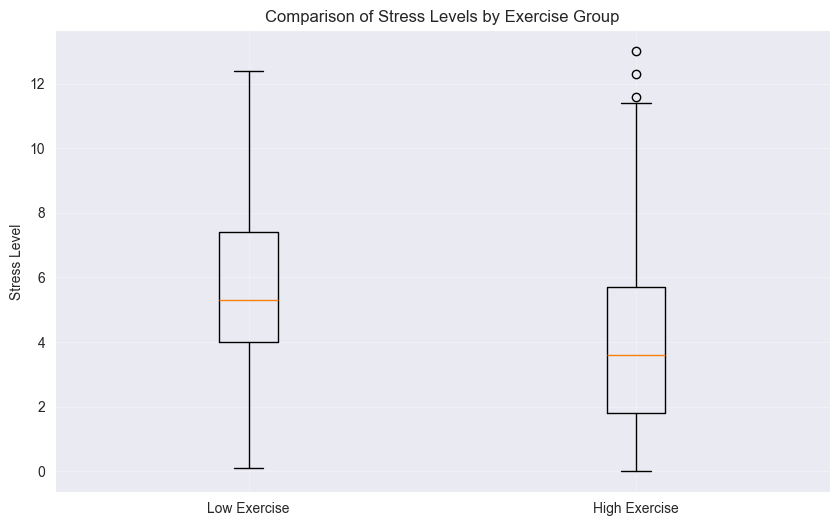

In [26]:
# Create a box plot to visualize the difference
plt.figure(figsize=(10, 6))
box_data = [low_stress, high_stress]
box_labels = ['Low Exercise', 'High Exercise']

plt.boxplot(box_data, tick_labels=box_labels)
plt.ylabel('Stress Level')
plt.title('Comparison of Stress Levels by Exercise Group')

plt.grid(True, alpha=0.3)
plt.show()


At the end we can that there is significant difference between the two groups' shape of distributions, and low-stress students tend to have higher physical activity hours per day compared to high-stress students (from the box plot). The Mann-Whitney U test confirms this observation with a p-value < 0.01.

### 5. Bootstrap Method
Bootstrapping is a resampling technique that allows us to estimate the sampling distribution of a statistic by repeatedly sampling with replacement from our data. We'll use bootstrapping to:
1. Estimate the difference in means and medians between the two groups
2. Calculate confidence intervals for these differences
3. Determine if there's a significant difference (if the confidence interval doesn't contain 0)


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

# Number of bootstrap samples
n_bootstraps = 5000

# Arrays to store bootstrap statistics
bootstrap_diff_means = np.zeros(n_bootstraps)
bootstrap_diff_medians = np.zeros(n_bootstraps)

In [28]:
# Perform bootstrapping
for i in tqdm(range(n_bootstraps)):
    # Sample with replacement from both groups
    boot_low = np.random.choice(low_stress, size=len(low_stress), replace=True)
    boot_high = np.random.choice(high_stress, size=len(high_stress), replace=True)

    # Calculate statistics for this bootstrap sample
    bootstrap_diff_means[i] = np.mean(boot_low) - np.mean(boot_high)
    bootstrap_diff_medians[i] = np.median(boot_low) - np.median(boot_high)

100%|██████████| 5000/5000 [00:00<00:00, 6362.60it/s]


In [29]:
# Calculate confidence intervals (90%)
ci_mean_90 = np.percentile(bootstrap_diff_means, [5, 90])
ci_median_90 = np.percentile(bootstrap_diff_medians, [5, 90])


# Calculate confidence intervals (95%)
ci_mean_95 = np.percentile(bootstrap_diff_means, [2.5, 97.5])
ci_median_95 = np.percentile(bootstrap_diff_medians, [2.5, 97.5])

# Calculate confidence intervals (99%)
ci_mean_99 = np.percentile(bootstrap_diff_means, [0.5, 99.5])
ci_median_99 = np.percentile(bootstrap_diff_medians, [0.5, 99.5])

In [30]:
print("Bootstrap Results (5000 resamples):")
print("\nDifference in Means (Low - High):")
print(f"  Observed difference: {np.mean(low_stress) - np.mean(high_stress):.4f}")
print(f"  90% CI: [{ci_mean_90[0]:.4f}, {ci_mean_90[1]:.4f}]")
print(f"  95% CI: [{ci_mean_95[0]:.4f}, {ci_mean_95[1]:.4f}]")
print(f"  99% CI: [{ci_mean_99[0]:.4f}, {ci_mean_99[1]:.4f}]")
print(f"  Significant at 90%: {'Yes' if (ci_mean_90[0] > 0 or ci_mean_90[1] < 0) else 'No'}")
print(f"  Significant at 95%: {'Yes' if (ci_mean_95[0] > 0 or ci_mean_95[1] < 0) else 'No'}")
print(f"  Significant at 99%: {'Yes' if (ci_mean_99[0] > 0 or ci_mean_99[1] < 0) else 'No'}")

print("\nDifference in Medians (Low - High):")
print(f"  Observed difference: {np.median(low_stress) - np.median(high_stress):.4f}")
print(f"  90% CI: [{ci_median_90[0]:.4f}, {ci_median_90[1]:.4f}]")
print(f"  95% CI: [{ci_median_95[0]:.4f}, {ci_median_95[1]:.4f}]")
print(f"  99% CI: [{ci_median_99[0]:.4f}, {ci_median_99[1]:.4f}]")
print(f"  Significant at 90%: {'Yes' if (ci_median_90[0] > 0 or ci_median_90[1] < 0) else 'No'}")
print(f"  Significant at 95%: {'Yes' if (ci_median_95[0] > 0 or ci_median_95[1] < 0) else 'No'}")
print(f"  Significant at 99%: {'Yes' if (ci_median_99[0] > 0 or ci_median_99[1] < 0) else 'No'}")

Bootstrap Results (5000 resamples):

Difference in Means (Low - High):
  Observed difference: 1.6209
  90% CI: [1.3628, 1.8227]
  95% CI: [1.3114, 1.9286]
  99% CI: [1.2284, 2.0235]
  Significant at 90%: Yes
  Significant at 95%: Yes
  Significant at 99%: Yes

Difference in Medians (Low - High):
  Observed difference: 1.7000
  90% CI: [1.4000, 2.1000]
  95% CI: [1.4000, 2.3000]
  99% CI: [1.3000, 2.5000]
  Significant at 90%: Yes
  Significant at 95%: Yes
  Significant at 99%: Yes


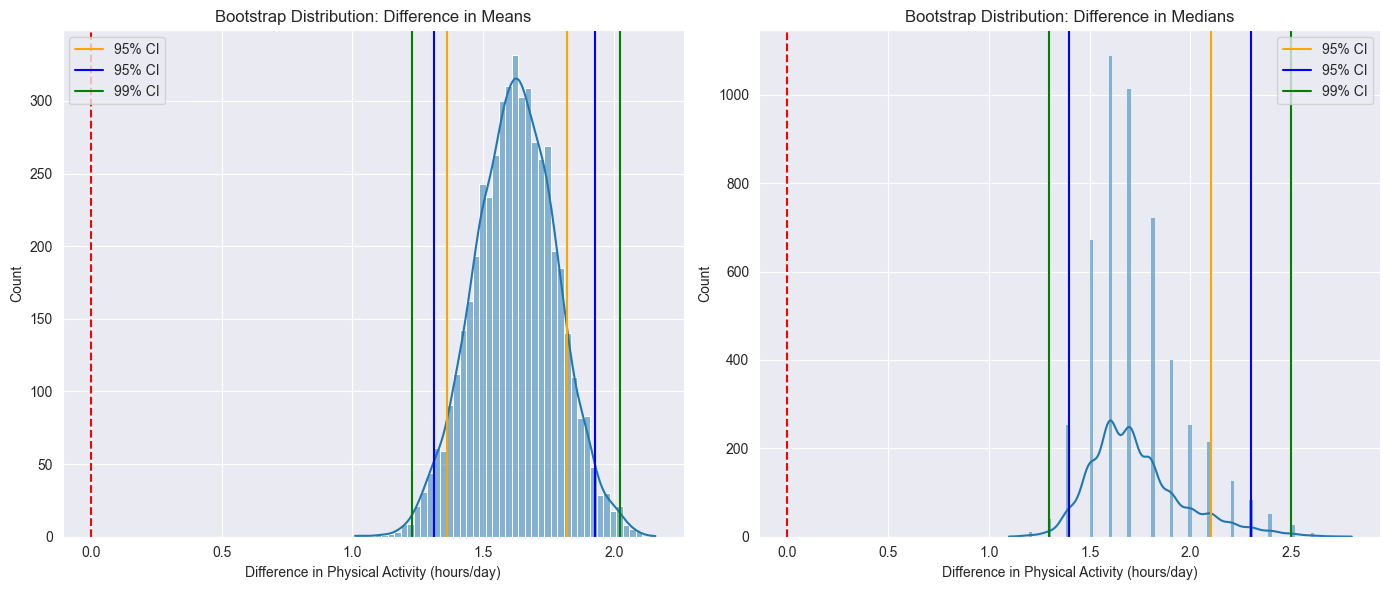

In [31]:
# Visualize bootstrap distributions
plt.figure(figsize=(14, 6))

# Plot bootstrap distribution of difference in means
plt.subplot(1, 2, 1)
sns.histplot(bootstrap_diff_means, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.axvline(x=ci_mean_90[0], color='orange', linestyle='-', label='95% CI')
plt.axvline(x=ci_mean_90[1], color='orange', linestyle='-')
plt.axvline(x=ci_mean_95[0], color='blue', linestyle='-', label='95% CI')
plt.axvline(x=ci_mean_95[1], color='blue', linestyle='-')
plt.axvline(x=ci_mean_99[0], color='green', linestyle='-', label='99% CI')
plt.axvline(x=ci_mean_99[1], color='green', linestyle='-')
plt.title('Bootstrap Distribution: Difference in Means')
plt.xlabel('Difference in Physical Activity (hours/day)')
plt.legend()

# Plot bootstrap distribution of difference in medians
plt.subplot(1, 2, 2)
sns.histplot(bootstrap_diff_medians, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.axvline(x=ci_median_90[0], color='orange', linestyle='-', label='95% CI')
plt.axvline(x=ci_median_90[1], color='orange', linestyle='-')
plt.axvline(x=ci_median_95[0], color='blue', linestyle='-', label='95% CI')
plt.axvline(x=ci_median_95[1], color='blue', linestyle='-')
plt.axvline(x=ci_median_99[0], color='green', linestyle='-', label='99% CI')
plt.axvline(x=ci_median_99[1], color='green', linestyle='-')
plt.title('Bootstrap Distribution: Difference in Medians')
plt.xlabel('Difference in Physical Activity (hours/day)')
plt.legend()

plt.tight_layout()
plt.show()


***Bootstrap Analysis Interpretation***

The bootstrap analysis provides a robust estimate of the difference in physical activity hours between students with low stress and those with high stress.

Key findings:
Since the confidence intervals for both means and medians do not contain zero, we can conclude that there is a significant difference in physical activity hours between the two groups. This aligns with our earlier findings from the Mann-Whitney U test.



### 6. CLT approach to test the hypothesis

Let's test the hypothesis:
- Null Hypothesis (H0): There is no difference in physical activity hours between people with low and high stress levels.
- Alternative Hypothesis (H1): People with low stress levels spend more time exercising than people with high stress levels.


In [32]:
# Sample sizes
n_low = len(low_stress)
n_high = len(high_stress)

# Sample means
mean_low = low_stress.mean()
mean_high = high_stress.mean()

# Sample standard deviations
std_low = low_stress.std()
std_high = high_stress.std()

print(f"Low stress group: n={n_low}, mean={mean_low:.2f}, std={std_low:.2f}")
print(f"High stress group: n={n_high}, mean={mean_high:.2f}, std={std_high:.2f}")
print(f"Difference in means (Low - High): {mean_low - mean_high:.2f}")


Low stress group: n=297, mean=5.58, std=2.38
High stress group: n=1029, mean=3.96, std=2.60
Difference in means (Low - High): 1.62


let's comapare the variances

In [33]:
import pingouin as pg

In [34]:
result = pg.homoscedasticity([np.array(low_stress), np.array(high_stress)], method='levene')
print(result)

               W      pval  equal_var
levene  3.568527  0.059103       True


In [36]:
t_stat, p_value = stats.ttest_ind(low_stress, high_stress, equal_var=True)

In [37]:
t_stat, p_value

(np.float64(9.631043537221803), np.float64(2.8883245376474363e-21))

Since p-value (2.8883245376474363e-21) < alpha on all reasonable confidence levels, we reject the null hypothesis.
Conclusion: People with low stress levels spend significantly more time exercising than people with high stress levels.

### Conclusion
In this analysis, we explored the relationship between stress levels and physical activity hours among students. Bootstrap, Mann Whitney U and T-test (with CLT) revealed that there is a significant difference in physical activity hours between low-stress and high-stress students. Low-stress students tend to engage in more physical activity compared to their high-stress counterparts. Comparing the medians and means suggest that promoting physical activity may be beneficial for stress management among students since people who exercise regularly have lower stress levels compared to those who don't.
